#### Kaggle link: https://www.kaggle.com/datasets/oktayrdeki/heart-disease/data

In [50]:
# Importing the required libraries and modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
import dtale
from ydata_profiling import ProfileReport
from sklearn.preprocessing import OrdinalEncoder
import streamlit as st
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import joblib

In [41]:
# Ignore warnings

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [44]:
# Loading dataset

df = pd.read_csv('/home/momtahin/Documents/Heart Disease Detaction/data/heart_disease.csv')

In [ ]:
# Creating a data summary report using "D-Tale"

d_tale = dtale.show(df) # Start D-Tale (Preferred method)
d_tale.open_browser() # Open the browser to view the report

In [45]:
# Missing value handling

print(df.isnull().sum())

# In column named 'Alcohol Consumption' null value is for no consumption. It's needed to be modified.
df['Alcohol Consumption'].fillna(value="Zero", inplace=True)

print(f'Percentage of rows with at least one missing data: {(df.isnull().any(axis=1).sum())/100}%')

Age                       29
Gender                    19
Blood Pressure            19
Cholesterol Level         30
Exercise Habits           25
Smoking                   25
Family Heart Disease      21
Diabetes                  30
BMI                       22
High Blood Pressure       26
Low HDL Cholesterol       25
High LDL Cholesterol      26
Alcohol Consumption     2586
Stress Level              22
Sleep Hours               25
Sugar Consumption         30
Triglyceride Level        26
Fasting Blood Sugar       22
CRP Level                 26
Homocysteine Level        20
Heart Disease Status       0
dtype: int64
Percentage of rows with at least one missing data: 4.68%


/tmp/ipykernel_3628/3444037687.py:6: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [47]:
# Define features and target variable

X = df.drop('Heart Disease Status', axis=1) # Removes 'Heart Disease Status' from df, assigning remaining features to X.
y = df['Heart Disease Status']

In [48]:
# Split the data into training and testing sets. stratify=y preserves class proportions, ensuring a fair and representative split for training and testing. 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [49]:
# Outlier detection and treatment by creating boxplot to visualize the distribution of the columns

#%matplotlib inline
# Define a function to detect and treat outliers using the IQR method
def detect_outliers(input_col):
    Q1 = input_col.quantile(0.25) # Calculate the first quartile
    Q3 = input_col.quantile(0.75) # Calculate the third quartile
    IQR = Q3 - Q1 # Calculate the interquartile range
    lower_bound = Q1 - 1.5 * IQR # Calculate the lower bound
    upper_bound = Q3 + 1.5 * IQR # Calculate the upper bound
    return (input_col < lower_bound) | (input_col > upper_bound) # Return the outliers

num_col = X_train.select_dtypes(include=[np.number]).columns

for column in num_col:
    outliers = detect_outliers(X_train[column]) # Detect outliers by calling the detect_outliers function
    count = outliers.value_counts()
    if True in count and count[True] > 0:
        print(f"Outlier occurrences in {column}:", count, "\n") # Print unique occurrences of outliers (True for outlier otherwise False)
    else:
        print(f"Outlier occurrences in {column}:", 'Zero', "\n")
# Result: There was no significant outlier.

Outlier occurrences in Age: Zero 

Outlier occurrences in Blood Pressure: Zero 

Outlier occurrences in Cholesterol Level: Zero 

Outlier occurrences in BMI: Zero 

Outlier occurrences in Sleep Hours: Zero 

Outlier occurrences in Triglyceride Level: Zero 

Outlier occurrences in Fasting Blood Sugar: Zero 

Outlier occurrences in CRP Level: Zero 

Outlier occurrences in Homocysteine Level: Zero 



In [61]:


# Data preprocessing with pipelines
num_col = X_train.select_dtypes(include=[np.number]).columns
cat_col = X_train.select_dtypes(include=[object]).columns

# Numerical pipeline
num_pipeline = Pipeline(steps = [
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

# Categorical pipeline
cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Combine numerical and categorical pipelines
col_transformer = ColumnTransformer(transformers = [
    ('num_pipeline', num_pipeline, num_col),
    ('cat_pipeline', cat_pipeline, cat_col)
])

models = [
    ('Logistic Regression', LogisticRegression()),
    ('Random Forest', RandomForestClassifier()),
    ('SVM', SVC())
]

# Create the VotingClassifier with hard voting (majority vote). It will choose the class label with the majority of votes from the individual models.
voting_clf = VotingClassifier(estimators = models, voting = 'hard')

# Create a pipeline with pre-processing and the voting classifier
final_pipeline = Pipeline(steps=[
    ('preprocessor', col_transformer),
    ('voting_classifier', voting_clf)
])


# Train the model
final_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = final_pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8


In [62]:
# Save the model
joblib.dump(final_pipeline, filename="/home/momtahin/Documents/Heart Disease Detaction/src/model.pkl") # Save the model as a pickle file

['/home/momtahin/Documents/Heart Disease Detaction/src/model.pkl']

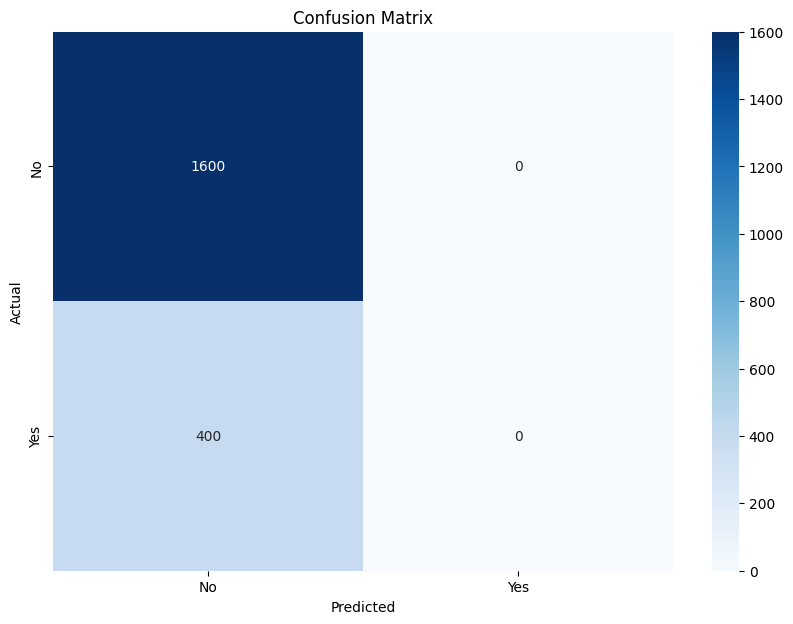

In [66]:
cm = confusion_matrix(y_test, y_pred)
class_names = y_test.unique()  # Define class names based on unique values in y_test
# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()